In [1]:
# import stringdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

data = pd.read_csv('/datasets/rest_data.csv')
data.object_name = data.object_name.str.lower()
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Для обного и того же объекта может быть разные типы и признак сети.
Найдем функцию, которая покажет самые частые тип объекта и параментр "chain" и присвоим объекту эти значения:

In [2]:
def dic(column):
    dic = (data.groupby(['object_name', column]).agg({'id':'count'})
                .sort_values(by=['object_name', column], ascending=[True,False]).reset_index()
                .groupby('object_name').agg({column:'first','id':'first'}))
    return dic[column].to_dict()

In [3]:
dic_type_obj = dic('object_type')
dic_chain = dic('chain')

data.apply(lambda x: dic_type_obj[x['object_name']], axis = 1)
data.apply(lambda x: dic_chain[x['object_name']], axis = 1)
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Для работы с дубликатами напишем цикл, который создаст автоматически словарь синонимов: хочу использовать предположение о том, что если слова однокоренные, то различие между строками будет минимальным (например, 3 символа). Поэтому я нахожу разницу между первой строкой и всеми остальными (алгоритм Левенштейна), и если она меньше трех - записываю в словарь.

Словарь будет следующего вида: {исходные_термин : массив_близких_терминов, ...}

In [4]:
unique_name = sorted(data['object_name'].unique().tolist())
unique_address = sorted(data['address'].unique().tolist())

In [5]:
# result = []
# obj_names = data['object_name'].head(300).unique().tolist()

# # enumerate - создает кортеж из индекса элемента и самого элемента
# for i, obj_name in enumerate(obj_names):
#     # чтобы два раза не перебирать
#     for obj_name2 in obj_names[i + 1:]:
#         lev_dist = edit_distance(obj_name, obj_name2)
#         if lev_dist <= 3:
#             result += [[obj_name, obj_name2, lev_dist]]
# result = pd.DataFrame(result, columns = ['source', 'alternative', 'lev_dist'])
# result = result.groupby('source').agg({'alternative': 'unique'})['alternative'].to_dict()
# result

К сожалению, достоверного справочника не получается, но он показывает основные "термины" - наиболее популярные варианты названий (seasrch_name).
    
Напишем функцию, которая составит словарь унифицированных названий объектов.

In [6]:
# data[data['object_name'].str.contains('иль-патио')].object_name.unique().tolist()

In [7]:
dict_ = {'шоколадница':['шоколадница', 'шоколадница кофе хаус', 'кофейня «шоколадница»', 'кафе «шоколадница»', 'кофейня шоколадница', 'шоколадница экспресс', 'шоколадница кофемания'],
         'макдоналдс':['макдоналдс', 'ресторан «макдоналдс»', 'предприятие быстрого обслуживания «макдоналдс»', 'москва - макдоналдс', 'кафе макдоналдс', 'кафе «макдоналдс»', 'ресторан«макдоналдс»'],
         'бургер кинг':['ресторан «бургер кинг»', 'бургер кинг', 'предприятие быстрого обслуживания «бургер кинг»', 'бургер кинг burger king', 'кафе бургер кинг', 'закусочная «бургер кинг»', 'кафе-закусочная «бургер кинг»', 'кафе «бургер кинг»', 'бургер кинг burger king', 'burgerking'],
         'bb burgers':['ресторан «bb burgers»','bb энд burger', 'bb grill', 'ресторан «bb grill»', 'ресторан «bb burgers»', 'bb & burgers'],
         'black star':['black star burgers', 'black star burger prime', 'black star burger'],
         'coffee moose':['coffee moose', 'кафе «coffee moose»', 'coffee moose кофейня','koffee moose'],
         'cofix':['cofix', 'cofix-bright', 'кофейня «cofix»', 'кофейня cofix', 'cofix+plombir'],
         'dim sum':['dim sun', 'dim sum & co', 'кафе dim sum & c0', 'dimsum&co', 'ресторан «dim sum & co»', 'dim sum', 'dim sum&co', 'dim&sam'],
         'вареничная': ['вареничная №1', 'вареничная № 1', 'вареничная', 'ресторан «вареничная №1»', 'вареничная (хинкальная)', 'кафе «вареничная №1»', 'вареничная 1'],
         'волконский':['волконский', 'кондитерская волконский', 'волконский у дома', 'кондитерская-пекарня волконский',  'пекарня «волконский хлеб»', 'пекарня волконский', 'кафе «волконский»', 'кафе волконский пекарня', 'кафе-пекарея «волконский»'],
         'суши сет':['суши сет', 'кафе «суши сет»', 'магазин-кулинария «суши сет»'],
         'суши wok': ['суши wok', 'сеть магазинов «суши wok»', 'кафе суши wok', 'кафе «суши wok»', 'бар «суши wok»'],
         'тратория': ['тратория semplice', 'тратория', 'тратория italian «паста&пицца»','траттория', 'траттория семпличе', 'траттория пепе', 'траттория на столешниковом', 'кафе «траттория венеция»', 'траттория венеция', 'траттория пане олио', 'траттория примавера', 'кафе траттория терраса', 'кафе «траттория модерна»', 'траттория stefano', 'кафе траттория', 'пиццерия траттория uno'],
         'столовая школа': ['столовая школа 58', 'столовая школа 98', 'столовая школа 1543', 'столовая школа «уна»', 'столовая школа «наши традиции»', 'столовая школа 38', 'столовая школа 37', 'столовая школа 14 (598)', 'столовая школа 14', 'столовая школа 74', 'столовая школа 571', 'столовая школа 1118', 'столовая школа 97', 'столовая школа 537 «комбинат дошкольного питания»', 'столовая школа 29', 'столовая школа 1485', 'столовая школа 875', 'столовая школа 875 (807)', 'столовая школа 803', 'столовая школа 73', 'столовая школа 99', 'столовая школа 262', 'столовая школа 71', 'столовая школа 261', 'столовая школа 804', 'столовая школа 712', 'столовая школа 79', 'столовая школа 84', 'столовая школа 1738', 'столовая школа 1741', 'столовая школа 1498', 'столовая школа 1905', 'столовая школа-интернат №15 циркового профиля им. ю.в. никулина для детей, оставшихся без попечения', 'столовая школа 1941', 'столовая школа 843 (812)', 'столовая школа 1448', 'столовая школа структурное подразделение №2 гбоу школы 2025', 'столовая школа 843', 'столовая школа 1248', 'столовая школа 916', 'столовая школа 1485 (созвездие)', 'столовая школа №939', 'столовая школа №937', 'столовая школа № 937'],
         'хинкальная': ['кафе «хинкальная»', 'хинкальная', 'хинкальная city', 'хинкальная (на м. бирюзова)', 'кафе хинкальная', 'хинкальная виноград', 'цинандали хинкальная', 'хинкальная 777', 'кафе хинкальная саамо', 'хинкальная «кахури»', 'хинкальная у бехо', 'хинкальная №1', 'мимино хинкальная', 'хинкальная кинто', 'хинкальная на спасской', 'хинкальная, пекарня', 'кафе хинкальная 11', 'хинкальная №5', 'хинкальная кахетия', 'кафе хинкальная грузинская кухня', 'ресторан хинкальная', 'хинкальная чела', 'новая хинкальная', 'хинкальная.джи', 'хинкальная батони', 'хинкальная № 1', 'm cafe хинкальная', 'marrakesh хинкальная', 'у михалыча хинкальная №1', 'грузинская кухня эzо хинкальная', 'вареничная (хинкальная)', 'ресторан «хинкальная»', 'хинкальная на арме', 'хинкальная салхино', 'хинкальная кера', 'хинкальная батоно', 'вах хинкальная'],
         'якитория':['ресторан «якитория»', 'кафе «якитория»', 'якитория', 'якитория и ян примус', 'кафе якитория', 'якитория и спорт бар'],
         'иль патио':['иль патио', 'иль патио планета суши', 'ресторан «иль патио»', 'шикари иль патио', 'кафе иль патио «il patio»', 'ресторан планета суши иль патио', 'кафе «иль патио»','иль-патио']}

In [8]:
def dic_unique_name(data):
    list={}
    seasrch_name = ['шоколадница', 'макдон', 'бургер кинг', 'bb burgers','black star', 'coffee moose', 'cofix', 
                    'dim sum', 'вареничная', 'волконский', 'суши сет', 'суши wok', 'тратория','столовая школа',
                    'хинкальная','якитория','иль патио']
    for name in seasrch_name:
        x = (data[data['object_name'].str.contains(name)]['object_name']).unique().tolist()
        list[name] = x
    return list

dic_unique_name = dic_unique_name(data)
dic_unique_name

{'шоколадница': ['шоколадница',
  'шоколадница кофе хаус',
  'кофейня «шоколадница»',
  'кафе «шоколадница»',
  'кофейня шоколадница',
  'шоколадница экспресс',
  'шоколадница кофемания'],
 'макдон': ['макдоналдс',
  'ресторан «макдоналдс»',
  'предприятие быстрого обслуживания «макдоналдс»',
  'москва - макдоналдс',
  'кафе макдоналдс',
  'кафе «макдоналдс»',
  'ресторан«макдоналдс»'],
 'бургер кинг': ['ресторан «бургер кинг»',
  'бургер кинг',
  'предприятие быстрого обслуживания «бургер кинг»',
  'бургер кинг burger king',
  'кафе бургер кинг',
  'закусочная «бургер кинг»',
  'кафе-закусочная «бургер кинг»',
  'кафе «бургер кинг»'],
 'bb burgers': ['ресторан «bb burgers»'],
 'black star': ['black star burgers',
  'black star burger prime',
  'black star burger'],
 'coffee moose': ['coffee moose',
  'кафе «coffee moose»',
  'coffee moose кофейня'],
 'cofix': ['cofix',
  'cofix-bright',
  'кофейня «cofix»',
  'кофейня cofix',
  'cofix+plombir'],
 'dim sum': ['dim sum & co',
  'кафе di

<font color='red'> После этого добавим новый столбец с унифицированным именем объекта - для тех заведений, у которых есть несколько вариантов названия. Если заведение в выборке одно - ставим None. Делаю это для того, чтобы потом по стобцу new_name убрать дубликаты. Ведь если значение None - повторов итак нет.

In [9]:
def new_name(seasrch_name):
    for key, value in dict_.items():
        if seasrch_name in value:
            return key
    return None

data['new_name'] = data.object_name.apply(new_name)
data.head()

,id,object_name,chain,object_type,address,number,new_name
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,None
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,None
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,None
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,None
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,None


Уберем дубликаты из датасета для дальнейшего анализа данных (используюстолбец с новыми названиями объектов, адресом и посадочными местами).

In [10]:
data_new = data.drop_duplicates(subset=['new_name','address','number'], keep="first")
# data_new = data[['object_name', 'new_name']].dropna().drop_duplicates()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 7 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
new_name       968 non-null object
dtypes: int64(2), object(5)
memory usage: 840.5+ KB


In [12]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13818 entries, 0 to 15365
Data columns (total 7 columns):
id             13818 non-null int64
object_name    13818 non-null object
chain          13818 non-null object
object_type    13818 non-null object
address        13818 non-null object
number         13818 non-null int64
new_name       966 non-null object
dtypes: int64(2), object(5)
memory usage: 863.6+ KB


Дубликатов больше нет, далее можно использовать в работе названия объектов из столбца object_name.

In [13]:
data_new.head()

,id,object_name,chain,object_type,address,number,new_name
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,None
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,None
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,None
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,None
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,None


## Шаг №2. Анализ данных

После того, как данные приведены к нужному типу и удалены дубликаты, можно начать анализировать данные для получения конкретных выводов.
    
Посмотрим, как соотносятся виды объектов общественного питания по количеству и покажем результаты на графике.
    
Так как в дальнейшем прийдется часто визуализировать данные, напишем функцию горизонтальной гистограммы (не прийдется в дальнейшем приводить графики к одному стилю).

In [14]:
def hist(x,y, data, title, color):
    fig, ax = plt.subplots(figsize=(x,y))        # размер графика
    ax.barh(data.iloc[:,0], data.iloc[:,1], color=color) # горизонтальный bar по данным + задаем цвет
    ax.set_title(title, loc='left', pad=12, fontweight="bold")   # заголовок графика + задаем шрифт
    for s in ['top','bottom','left','right']:                    # убираю все границы графика
        ax.spines[s].set_visible(False)                          
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)  # задаю только промежуточные границы по значениям
    for i in ax.patches:                                                     # цикл по значениям
        ax.text(i.get_width()+2, i.get_y()+0.5, str(round((i.get_width()), 2)),   # задаю отступ (+) для подписи
                fontsize=10, fontweight='bold', color='grey')                     # задаю шрифт и цвет подписи значения
    plt.show() 

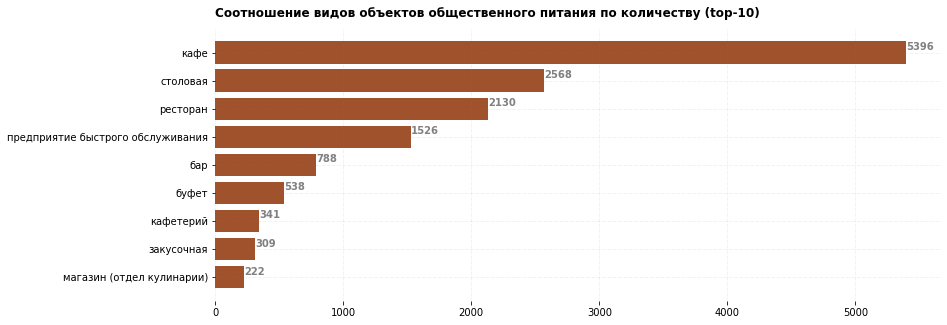

In [15]:
# соотношение видов объектов общественного питания по количеству
obj_top10 = (data_new.groupby(['object_type']).agg({'id':'nunique'}).reset_index()
     .sort_values('id', ascending = False).head(10))

img = hist(13,5, obj_top10.sort_values('id'), 
           'Cоотношение видов объектов общественного питания по количеству (top-10)', 'sienna')

Самый популярный вид объекта - кафе (в общей сложности по анализируемой территории из более 6 тысяч), почти в половину меньше столовых и ресторанов. Меньше всего открывают магазинов с отделами кулинарии.

Если говорить про распределение сетевых и несетевых объектов по анализируемой территории, результат следующий:

Text(0.0, 1.0, 'Соотношение сетевых и несетевых заведений по количеству')

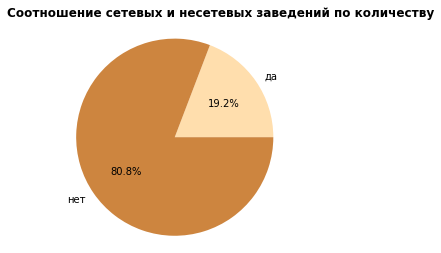

In [16]:
#  соотношение сетевых и несетевых заведений по количеству
chain_top = data_new.groupby(['chain']).agg({'id':'nunique'}).reset_index()
labels = chain_top.chain.tolist()
sizes = chain_top.id.tolist()
colors = ['navajowhite', 'peru']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
ax.axis('equal')
ax.set_title('Соотношение сетевых и несетевых заведений по количеству', pad=12, fontweight="bold", loc='left');

В столице и её пределах наиболее развиты несетевые заведения (80.7% от общего количества). Это значит, что подавляющее большинство объектов имеют менее 2-3 заведений одной сети.

 А какие объекты считаются сетевыми? Посмотрим на графике:

In [17]:
# для какого вида объекта общественного питания характерно сетевое распространение
chain_type_top = (data_new.query('chain == "да"')
                  .groupby(['object_type']).agg({'id':'nunique'})
                  .reset_index().sort_values('id', ascending = False))

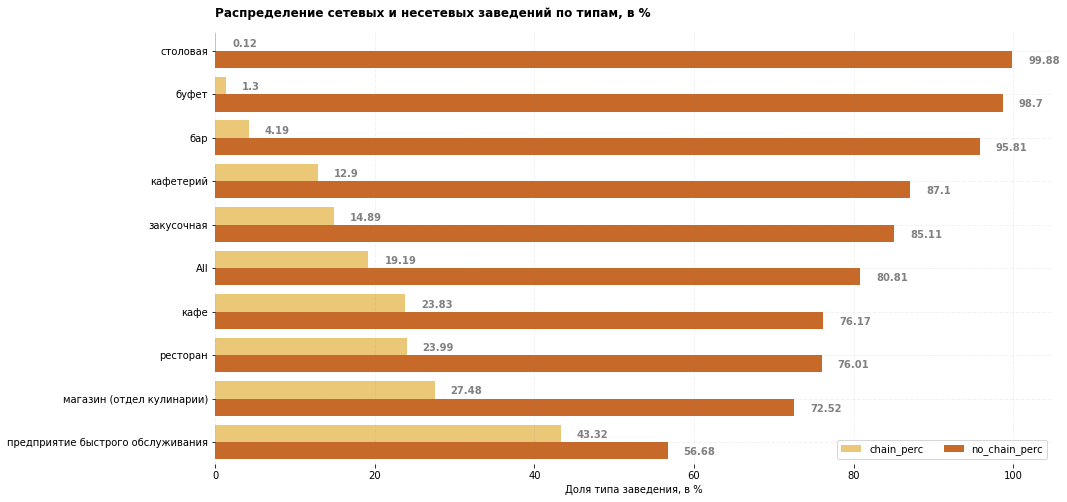

In [18]:
chain_type_top1 = data_new.pivot_table(index=['object_type'],
                                       columns='chain', 
                                       values='id', 
                                       aggfunc=['count'], 
                                       margins=True).reset_index()
chain_type_top1.columns = ['object_type', 'chain', 'not_chain', 'total']

chain_type_top1['chain_perc'] = round(chain_type_top1['chain'] / chain_type_top1['total'] * 100,2)
chain_type_top1['no_chain_perc'] = round(chain_type_top1['not_chain'] / chain_type_top1['total']* 100,2)

a = chain_type_top1[['object_type','chain_perc','no_chain_perc']].melt(id_vars=['object_type'], 
                                                                       var_name=['type_chain'], 
                                                                       value_name='perc').sort_values('perc')

f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x="perc", y="object_type", hue ='type_chain', data=a, palette='YlOrBr')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Доля типа заведения, в %")
ax.set_title('Распределение сетевых и несетевых заведений по типам, в %', loc='left', pad=12, fontweight="bold")
sns.despine(left=True, bottom=True)
for s in ['top','bottom','left','right']:                   
    ax.spines[s].set_visible(False)                          
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)  
for i in ax.patches:                                                     
    ax.text(i.get_width()+2, i.get_y()+0.3, str(round((i.get_width()), 2)), 
                fontsize=10, fontweight='bold', color='grey')

Как и отмечалось ранее, самый часто встречающийся сетевой тип объекта - предприятия быстрого обслуживания.
    
По графику видно, что у столовых, буфетов и баров самый низкий процент сетевых заведений (то есть их почти нет).
    
Чтобы понять, характерно ли для сетевых заведений большое или маленькое количество посадочных мест, а так же их распределение по количеству, посмотрим среднее распределение и выведем результаты на графики.
    
Для этого прежде всего найдем топовые (10) сетевые заведения и посмотрим, как часто они встречаются и с каким количеством посадочных мест.

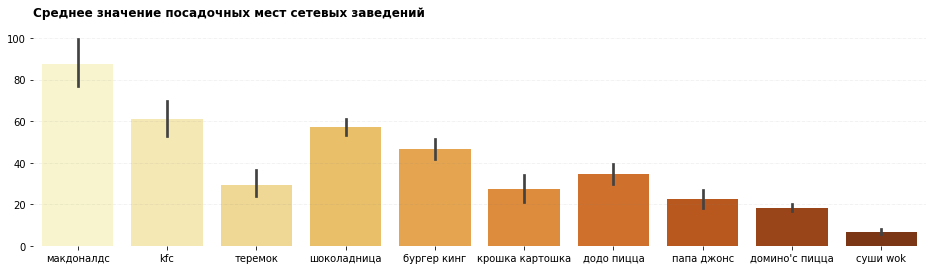

In [19]:
# Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или 
# мало заведений с большим количеством посадочных мест?

chain_name_top = (data_new.query('chain == "да"').groupby(['object_name']).agg({'id':'nunique'}).reset_index()
     .sort_values('id', ascending = False).head(10))['object_name'].to_list()

report = data_new[data_new['object_name'].isin(chain_name_top)][['object_name','number']]

fig, ax = plt.subplots(figsize=(16,4))
for s in ['top','bottom','left','right']:                    
        ax.spines[s].set_visible(False)
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

g = sns.barplot(x='object_name', y = 'number', data = report.sort_values('number', ascending = False), 
#                 order = ['макдоналдс', 'шоколадница','kfc','бургер кинг','теремок','папа джонс',
#                          'крошка картошка','суши wok','милти','домино''c пицца'],
                palette='YlOrBr').set_title('Среднее значение посадочных мест сетевых заведений', 
                                             loc='left', pad=12, fontweight="bold")

ax.set(xlabel=None, ylabel=None)
plt.show()

Самое большое среднее число посадочных мест у сетевого ресторана - более 90, маленькое - около 10.
    
Если усреднить показатели всех объектов, то примем за границу деления - 60 посадочных мест.
    
Сделала сортировку данных по количеству посадочных мест (столбец  number)

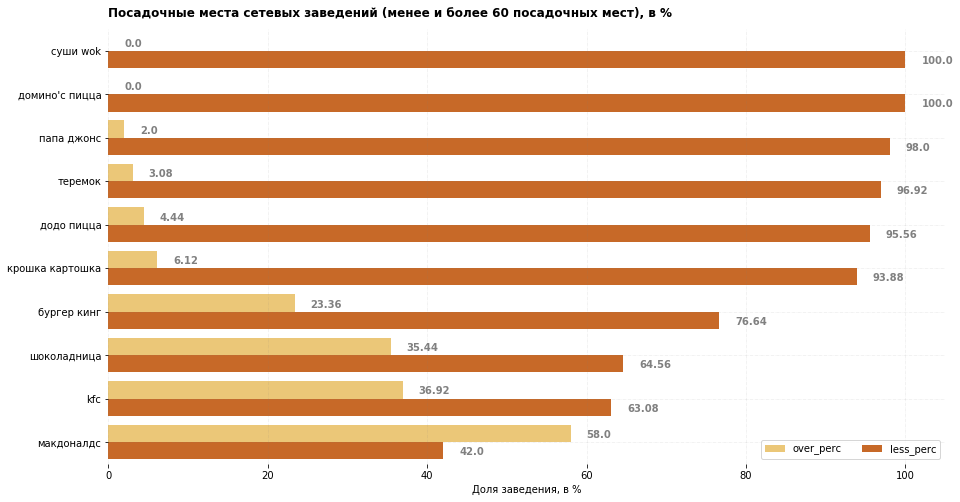

In [20]:
report['less 60'] = report['number'] <= 60
report['over 60'] = report['number'] > 60
        
report_last = (report.groupby(['object_name']).agg({'number':'count', 'less 60':'sum', 'over 60':'sum'}).reset_index())

report_last['less_perc'] = report_last['less 60'] / report_last['number'] * 100
report_last['over_perc'] = report_last['over 60'] / report_last['number'] * 100

b=report_last[['object_name','less_perc','over_perc']].melt(id_vars=['object_name'], 
                                                          var_name=['count_number'], 
                                                          value_name='perc').sort_values('perc')

f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x="perc", y="object_name", hue ='count_number', data=b, palette='YlOrBr')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Доля заведения, в %")
ax.set_title('Посадочные места сетевых заведений (менее и более 60 посадочных мест), в %', 
             loc='left', pad=12, fontweight="bold")
sns.despine(left=True, bottom=True)
for s in ['top','bottom','left','right']:                   
    ax.spines[s].set_visible(False)                          
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)  
for i in ax.patches:                                                     
    ax.text(i.get_width()+2, i.get_y()+0.3, str(round((i.get_width()), 2)), 
                fontsize=10, fontweight='bold', color='grey')

Вот и ответ на вопрос: сетевые заведения в большинстве случаев имееют много заведений с небольшим количеством посадочных мест. Конечно, все зависит от территории размещения заведения, но как и логично предположить, что конкуренция не позволяет быть "монополистом" в большом молле - каждый раз приходя в любой торговый центр, обычно можно встретить все популярные сетевые заведения.

Посмотрим, какое среднее количество посадочных мест у каждого типа заведения. Посмотрим результаты на графике.

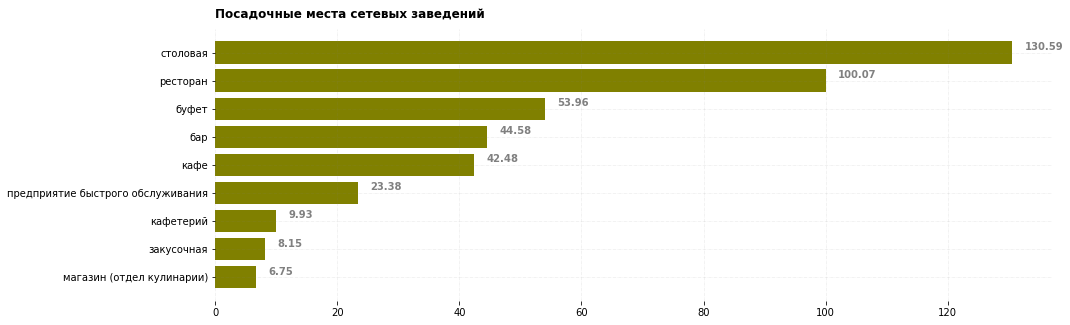

In [21]:
#  Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. 
# Какой вид предоставляет в среднем самое большое количество посадочных мест?

number_type_top = data_new.groupby(['object_type']).agg({'number':'mean'}).reset_index().sort_values('number', ascending = True)
hist(15,5,number_type_top , 'Посадочные места сетевых заведений', 'olive')

Столовые вмещают в себя самое большое количество желающих (около 130 человек в одном заведении). Это объясняется относительной дешевизной блюд, а следовательно, и доступностью для каждого жителя Москвы. 
 
Далее идут рестораны, которые в среднем могут усадить до 100 человек в одном заведении.
    
Буфет в среднем может предложить около 50 посадочных мест - такое заведение в большинстве случаем не предполагает длительное посещение людей.
    
А вот бар может предложить свои услуги в среднем для 40 людей - объясняется тем, что не все проводят пятничный вечер за бокалом вина :-)

Для того, чтобы провести детальный анализ, выделим в отдельный столбец информацию об улице объекта.
Выделение улицы делаем с помощь регулярного выражения.

In [22]:
# Выделите в отдельный столбец информацию об улице из столбца address
pattern = '\,(([а-яА-Я0-9\-ё\s"]+)?(аллея|бульвар|деревня|квартал|километр|корпус|линия|микрорайон|набережная|переулок|площадь|посёлок|проезд|просек|проспект|территория|тупик|улица|шоссе|село)([а-яА-Яё0-9\-\s"]+)?)\,'

data_new['street'] = data_new['address'].str.extract(pat = pattern)[0]
data_new[['address', 'street']].query('street.isna()')

#\, - кусок строки должен начинаться с запятой и заканчиваться запятой
#((.+)?(улица|переулок|шоссе)(.+)?) - т.н. capture group - то, что будет извлекаться
#здесь
#(.+)? - опциональный (поэтому ?) кусок строки, содержащий любые символы
#(улица|переулок|шоссе) - слово "улица" или "переулок" или "шоссе"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,address,street
859,"Партизанская улица, дом 30",NaN
1405,"город Москва, город Зеленоград, корпус 401",NaN
1406,"город Москва, город Зеленоград, корпус 435",NaN
1407,"город Москва, город Зеленоград, корпус 436",NaN
1408,"город Москва, город Зеленоград, корпус 438",NaN
...,...,...
14470,"город Москва, город Зеленоград, корпус 1627",NaN
14473,"город Москва, город Зеленоград, корпус 1602А",NaN
14478,"город Москва, город Зеленоград, корпус 532",NaN
15137,"город Москва, город Зеленоград, Проезд № 4806,...",NaN


Все, что не найдено (выведено вверху) - в большинстве случаев - город Зеленоград, который в дальнейшем анализе не участвует. Поэтому 198 записями можно пренебречь.
    
Построим график топ-10 улиц по количеству объектов общественного питания. А еще посмотрим, в каких районах находятся данные улицы.

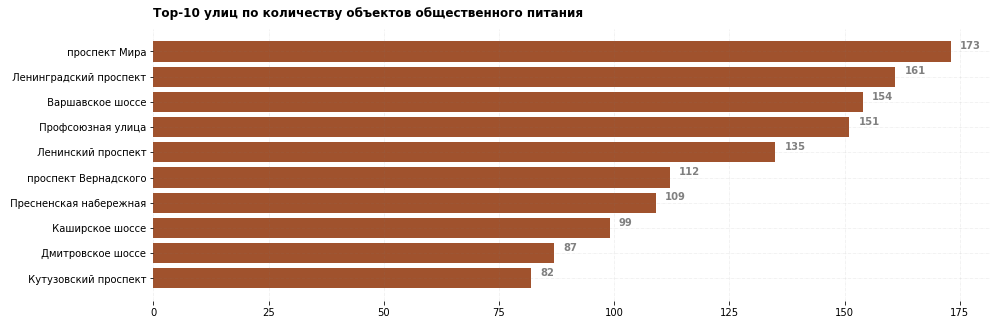

In [23]:
street_top = (data_new.groupby(['street']).agg({'id':'nunique'}).reset_index().sort_values('id', ascending = False).head(10))

hist(15,5,street_top.sort_values('id', ascending = True), 'Top-10 улиц по количеству объектов общественного питания', 'sienna')

Для этого можно использовать несколько вариантов.
    
Во-первых, я использую пакет для геолокации (folium), чтобы отметить все объекты из топового списка (выше) на карте. К сожалению, тренажер не позволяет вывести результат, поэтому я сохранила его в расширении *.html локально на компьютере, а сюда вставила объект для вывода.
    
Надем районы, через которые чаще всего проходят топовские улицы (ares - top_house). Они и отмечаны на карте.

In [25]:
# Надем районы, через которые чаще всего проходят топовские улицы
data_new.address.replace("владение","дом").replace('домовладение', 'дом')
data_new['house'] = data_new['address'].str.rpartition(', дом ')[2]  

top_house = (data_new[data_new['street'].isin(street_top['street'].str.strip().unique().tolist())]
                                        .groupby(['street','house'])
                                        .agg({'id':'nunique'})
                                        .reset_index()
                                        .sort_values('id', ascending = False))

top_house = top_house.groupby(['street']).agg({'house':'max','id':'max'}).reset_index()

top_house['area'] = ['квартал № 123',
                     'район Москворечье-Сабурово',
                     'район Чертаново Центральное',
                     'район Фили-Давыдково',
                     'Хорошёвский район',
                     'Обручевский район',
                     'Пресненский район',
                     'район Коньково',
                     'район Раменки',
                     'Останкинский район']

top_house.area

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0                  квартал № 123
1     район Москворечье-Сабурово
2    район Чертаново Центральное
3           район Фили-Давыдково
4              Хорошёвский район
5              Обручевский район
6              Пресненский район
7                 район Коньково
8                  район Раменки
9             Останкинский район
Name: area, dtype: object

Посмотрим  распределение заведения на карте: https://disk.yandex.ru/client/recent?idApp=client&dialog=slider&idDialog=%2Fdisk%2F%D0%92%D1%8B%D0%BF%D1%83%D1%81%D0%BA%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82%2Fmap.png

Во-вторых, раз уж я показала топ улиц - лидер по заведениям - проспект Мира	- а он находится в ЦАО.
В завершении, можно использовать внешний источник по разбивке улиц Москвы на районы (*.csv).

In [27]:
districts = pd.read_csv('http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv')
districts = districts.groupby(['streetname']).agg({'okrug':'first'}).reset_index()

Посмотрим, какие районы самые топовые по количеству объектов.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


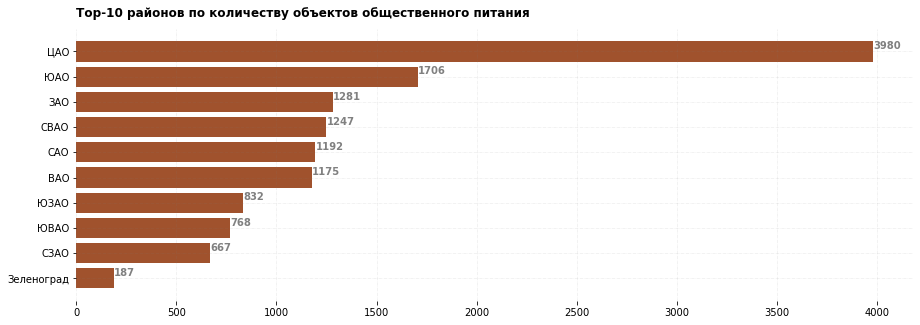

In [28]:
data_new['street'] = data_new['street'].str.strip()

top_okrug = pd.merge(left=data_new, right=districts, left_on='street', 
                     right_on='streetname')[['okrug','id']].groupby(['okrug']).count().reset_index()

hist(15,5,top_okrug.sort_values('id', ascending = True),
     'Top-10 районов по количеству объектов общественного питания', 'sienna')

Как и ожидалось, самый большой охват по кол-ву объектов в ЦАО, далее Юг и Запад.
    
Интересно, а есть ли улицы с один типом объекта общественного питания? Сколько их по районам?

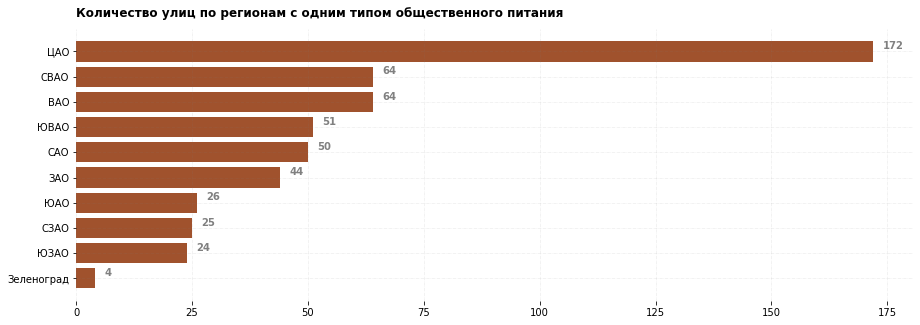

In [29]:
# Найдите число улиц с одним объектом общественного питания. 
# Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

count_steet = (pd.merge(left=data_new, right=districts, left_on='street', right_on='streetname')
 .pivot_table(index=['street', 'okrug'], values='object_type', aggfunc = 'count')
 .reset_index()
 .query('object_type == 1'))

count_steet = count_steet.groupby('okrug').agg({'street':'nunique'}).reset_index().sort_values('street', ascending = True)

hist(15,5,count_steet, 'Количество улиц по регионам с одним типом общественного питания', 'sienna')

В ЦАО 171 улиц могут похвастаться только одним типом объекта!
    
Как распределяется количество посадочных мест для топовых улиц?

Думаю, что в ЦАО большая конкуренция между объектами, и следовательно, отдельную улицу "захватывает" конкретный тип заведения.

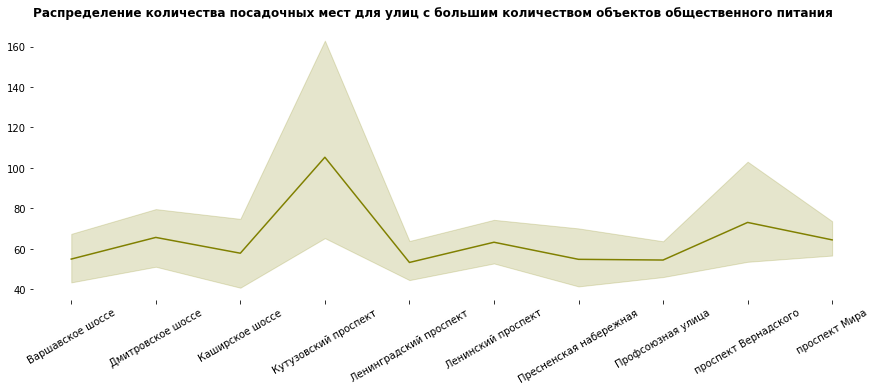

In [30]:
# Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. 
# Какие закономерности можно выявить?

st_by_number = data_new[data_new['street'].isin(street_top['street'].str.strip().unique().tolist())]
f, ax = plt.subplots(figsize=(15, 5))

g = sns.lineplot(x="street", y="number", data=st_by_number, color='olive')

ax.set(ylabel="", xlabel="")

for item in g.get_xticklabels():
    item.set_rotation(30)
    
ax.set_title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания', 
             loc='left', pad=12, fontweight="bold")

sns.despine(left=True, bottom=True)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


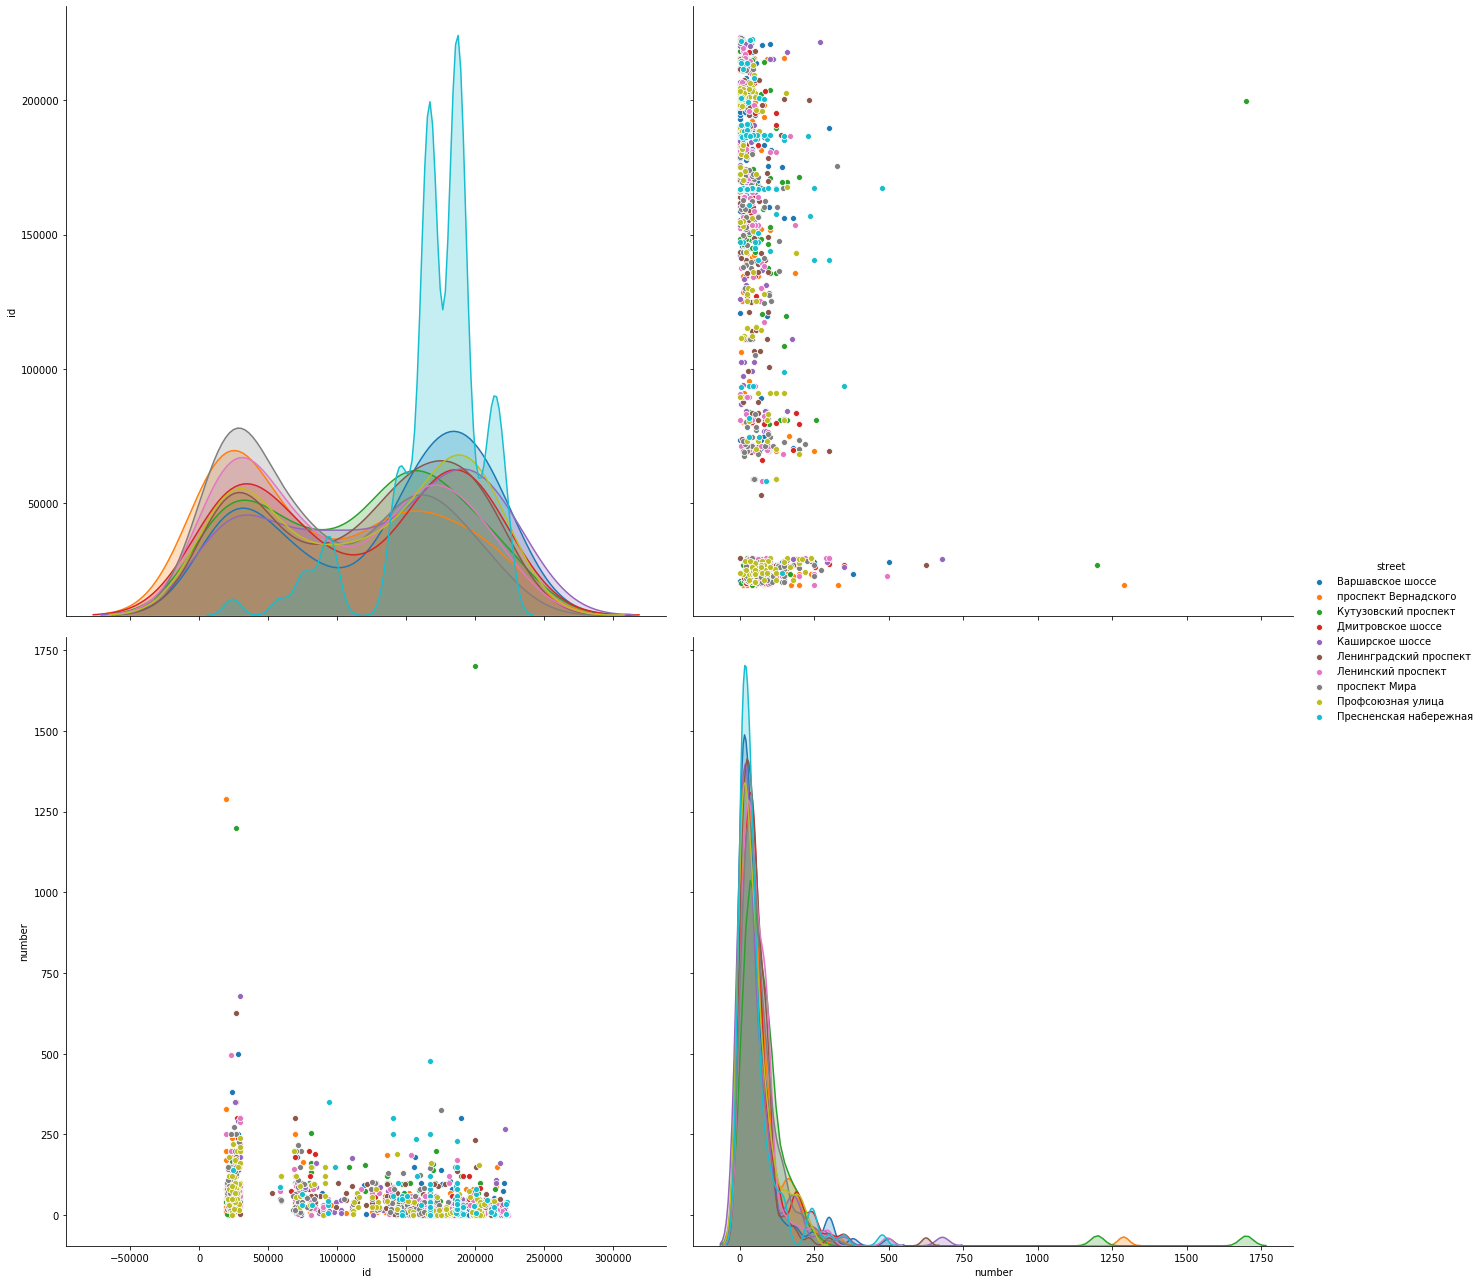

In [31]:
sns.pairplot(st_by_number, hue='street', size=9);

 На Кутузовском проспекте самый большой разброс и, соответственно, максимум по среднему кол-ву посадочных мест.

## Итоги:
    
Самое перспективное заведение на данный момент - сетевое кафе. С небольшим количеством посадочных мест, но развитой сетью. Такие характеристики сейчас носят топовые заведения Москвы. 
    
Если говорить про территорию: по месторасположению лидирует ЦАО, в частности Кутузовский проспект (при этом он не является лидиров по количеству сетевых заведений). Следовательно, данная территория является перспективной для дальнейшего освоения, - около 171 улиц ЦАО погут похвастаться только одним типом заведения. 
    
Учитывая тип заведения, территорию размещения, а также новизну "подачи" открываемого объекта, может быть обеспечен большой охват клиентов. 

## Шаг №3. Презентация для инвестеров

доступна по ссылке: https://yadi.sk/i/f5wo_ulzWRXyeQ